In [1]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-2wcw7zsw
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-2wcw7zsw
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 4.5 MB/s eta 0:00:00
  Created wheel for text-flappy-bird-gym: filename=text_flappy_bird_gym-0.1.1-py3-none-any.whl size=7772 sha256=8782348ef594b9609f6b71962b9ed2a4fc3680e2b3b80abfa54b24af8615519c
  Stored in directory: /tmp/pip-ephem-wheel-cache-vqf5mjb_/wheels/41/44/75/c67b96ba782472d8cacb00e3af57e29d1ee3a14f2e95a59ce5
Successfully built text-flappy-bird-gym


In [2]:
!pip install flappy-bird-gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.1/558.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_flappybird_values(V):

    def get_Z(x, y):
        if (x,y) in V:
            return V[x,y]
        else:
            return 0

    def get_figure(ax):
        x_range = np.arange(0, 13)
        y_range = np.arange(-12, 11)
        X, Y = np.meshgrid(x_range, y_range)

        Z = np.array([get_Z(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.magma, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, 110)
        surf.set_edgecolor('k')
        surf.set_linewidth(0.5)
        plt.grid(False)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('TextFlappyBird-v0: State-Value plot')
    get_figure(ax)
    plt.show()

def plot_flappybird_policy(policy):
    def get_Z(x, y):
        return policy.get((x, y), 1)

    def get_figure():
        x_range = np.arange(0, 13, 1)
        y_range = np.arange(-12, 11, 1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x, y) for x in x_range] for y in y_range])
        plt.imshow(Z, cmap=plt.get_cmap('viridis', 2), vmin=0, vmax=1)
        plt.xticks(x_range)
        plt.yticks(range(23), [y for y in y_range])
        plt.gca().invert_xaxis()
        plt.xlabel('Distance from pipe (X-axis)')
        plt.ylabel('Distance from pipe (Y-axis)')
        plt.title('TextFlappyBird-v0: Policy plot')
        plt.grid(color='w', linestyle='-', linewidth=1)

    plt.figure(figsize=(10, 10))
    get_figure()
    plt.show()


In [4]:
%matplotlib inline
import os, sys
import gymnasium as gym
import time
import text_flappy_bird_gym
from collections import defaultdict

import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt

from tqdm import tqdm
import pickle
from mpl_toolkits.mplot3d import axes3d

# Environment setup and baseline policy

In [8]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
print(env.reset())
print(env.observation_space)
print(env.action_space)
# state space x: [0, 13]
# state space y: [-12, 11]
# total space: 14*22 = 308

((13, 1), {'score': 0, 'player': [6, 7], 'distance': 13.038404810405298})
Tuple(Discrete(14), Discrete(22, start=-11))
Discrete(2)


In [12]:
env = gym.make('TextFlappyBird-screen-v0', height = 15, width = 20, pipe_gap = 4)
print(env.reset())
print(env.observation_space)
print(env.action_space)

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0

## Random action

In [ ]:
# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()
action = env.action_space.sample()
obs, reward, done, _, info = env.step(action)

# iterate
while True:
    # Select next action
    action = env.action_space.sample()
    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    print('action:', action)
    print('obs:', obs)
    print('reward:', reward)
    print('done:', done)
    print('info:', info)
    time.sleep(0.2) # FPS
    # If player is dead break
    if done:
        break
env.close()

Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=-3)
action: 1
obs: (11, -3)
reward: 1
done: False
info: {'score': 0, 'player': [6, 5], 'distance': 11.40175425099138}
Text Flappy Bird!
Score: 0
----------------------
[                |   ]
[                |   ]
[                |   ]
[                |   ]
[      @         |   ]
[                |   ]
[                    ]
[                    ]
[                    ]
[                    ]
[                |   ]
[                |   ]
[                |   ]
[                |   ]
[                |   ]
^^^^^^^^^^^^^^^^^^^

## Baseline rule-based policy (no learning)

In [ ]:
def policy(observation):
    """
    A policy that
    """
    dx, dy = observation
    if dy in range(-2, 1):
      return 0
    elif dy < -2:
      return 0
    else:
      return 1

In [ ]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
num_episodes = 50
total_reward = []

for episode in range(num_episodes):
  state, _ = env.reset()
  action = policy(state)
  state, reward, done, _, info = env.step(action)
  reward_sum = reward

  # iterate
  while True:
      # Select next action
      action = policy(state)
      # Appy action and return new observation of the environment
      state, reward, done, _, info = env.step(action)
      reward_sum += reward
      if done:
        break
  total_reward.append(reward_sum)

print('Average return per episode under artificial policy:', np.mean(total_reward))

Average return per episode under artificial policy: 136.28


# Reinforcement Learning: Model Free Control methods

In [13]:
import sys
import numpy as np
from collections import defaultdict

class MonteCarloControl:
  def __init__(self, env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    #Initialize with parameters
    self.env = env
    self.num_A = env.action_space.n
    self.Q = defaultdict(lambda: np.zeros(self.num_A))
    self.epsilon = eps_start
    self.num_episodes = num_episodes
    self.alpha = alpha
    self.gamma = gamma
    self.eps_decay = eps_decay
    self.eps_min = eps_min


  def generate_episode_from_Q(self):
      """ generates an episode from following the epsilon-greedy policy """
      episode = []
      state_full = self.env.reset()
      #retrieve the distance to pipe as our state
      state = state_full[0]
      while True:
          if state in self.Q:
            action = np.random.choice(np.arange(self.num_A), p=self.get_probs(state))
          else:
            action = self.env.action_space.sample()

          # take a step in the environement
          next_state, reward, done, _ , info = self.env.step(action)
          episode.append((state, action, reward))
          state = next_state
          if done:
              break
      return episode

  def get_probs(self, state):
      """ obtains the action probabilities corresponding to epsilon-greedy policy """
      Q_s = self.Q[state]
      policy_s = np.ones(self.num_A) * self.epsilon / self.num_A
      best_a = np.argmax(Q_s)
      policy_s[best_a] = 1 - self.epsilon + (self.epsilon/self.num_A)
      return policy_s

  def update_Q(self, episode):
      """ updates the action-value function estimate using the most recent episode """
      states, actions, rewards = zip(*episode)
      # prepare for discounting
      discounts = np.array([self.gamma ** i for i in range(len(rewards)+1)])
      for i, state in enumerate(states):
          old_Q = self.Q[state][actions[i]]  # Old Q-value
          self.Q[state][actions[i]] = old_Q + self.alpha * (sum(rewards[i:] * discounts[:-(1+i)]) - old_Q)  # Update Q-value using SARSA
      return Q

  def run_mc(self):
    # loop over episodes
    for i_episode in range(1, self.num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, self.num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(self.epsilon * self.eps_decay, self.eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = self.generate_episode_from_Q()  # Call generate_episode_from_Q function
        # update the action-value function estimate using the episode
        self.Q = self.update_Q(episode)  # Call update_Q function
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q


## Agent 1: Monte Carlo Control

In [14]:
class MonteCarloAgent:
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.

        Args:
            agent_init_info (dict): The parameters used to initialize the agent. The dictionary contains:
                {
                    num_states (int): The number of states,
                    num_actions (int): The number of actions,
                    epsilon (float): The epsilon parameter for exploration,
                    step_size (float): The step-size,
                    discount (float): The discount factor,
                }
        """
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info.get("seed", None))

        # Create an array for action-value estimates and initialize it to zero.
        self.Q = {}
        self.episode = []

    def check_state_explored(self, state):
        for action in range(self.num_actions):
            if (state, action) not in self.Q:
                self.Q[(state, action)] = 0

    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.

        Args:
            state (int): the state from the environment's env_start function.

        Returns:
            int: the first action the agent takes.
        """
        self.check_state_explored(state)

        # Choose action using epsilon greedy.
        current_q = [self.Q[(state, 0)], self.Q[(state, 1)]]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action

    def agent_step(self, reward, state):
        """A step taken by the agent.

        Args:
            reward (float): the reward received for taking the last action taken.
            state (int): the state from the environment's step based on where the agent ended up after the last step.

        Returns:
            int: the action the agent is taking.
        """
        self.check_state_explored(state)
        # Choose action using epsilon greedy.
        current_q = [self.Q[(state, 0)], self.Q[(state, 1)]]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)

        self.episode.append((self.prev_state, self.prev_action, reward))
        self.prev_state = state
        self.prev_action = action
        return action

    def agent_end(self, reward):
        """Run when the agent terminates.

        Args:
            reward (float): the reward the agent received for entering the terminal state.
        """
        # Update Q-values for the entire episode
        G = 0
        for (state, action, reward) in reversed(self.episode):
            G = self.discount * G + reward
            self.Q[state, action] += self.step_size * (G - self.Q[state, action])
        self.episode = []  # Reset episode buffer

    def argmax(self, q_values):
            """Argmax function for selecting action."""
            top = np.max(q_values)
            ties = np.where(q_values == top)[0]
            return self.rand_generator.choice(ties)

## Agent 2: Sarsa (on-policy TD control)

In [15]:
class SarsaAgent:
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.

        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }

        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])

        # Create an array for action-value estimates and initialize it to zero.
        self.Q = {}
        self.episode = []

    def check_state_explored(self, state):
        for action in range(self.num_actions):
            if (state, action) not in self.Q:
                self.Q[(state, action)] = 0


    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """

        # Choose action using epsilon greedy.
        self.check_state_explored(state)
        current_q = [self.Q[(state, 0)], self.Q[(state, 1)]]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """

        # Choose action using epsilon greedy.
        self.check_state_explored(state)
        current_q = [self.Q[(state, 0)], self.Q[(state, 1)]]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)


        ######### Update for Expected Sarsa ################
        # Perform an update
        # non_greedy_action_probability = self.epsilon / self.num_actions
        # greedy_action_probability = ((1 - self.epsilon)) + non_greedy_action_probability
        # expected_term = 0
        # for a in range(self.num_actions):
        #     if a == np.argmax(self.q[state,:]):
        #         expected_term += self.Q[state, a] * greedy_action_probability
        #     expected_term += self.Q[state, a] * non_greedy_action_probability
        # self.Q[self.prev_state, self.prev_action] += self.step_size * (reward + self.discount * expected_term - self.Q[self.prev_state, self.prev_action])
        #####################################################

        predict = self.Q[self.prev_state, self.prev_action]
        target = reward + self.discount * self.Q[state, action]
        self.Q[self.prev_state, self.prev_action] += self.step_size * (target - predict)

        self.prev_state = state
        self.prev_action = action
        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        self.Q[self.prev_state, self.prev_action] += self.step_size * (reward - self.Q[self.prev_state, self.prev_action])

    def argmax(self, q_values):
            """Argmax function for selecting action."""
            top = np.max(q_values)
            ties = np.where(q_values == top)[0]
            return self.rand_generator.choice(ties)

# Simulation

In [16]:
def simulate_test(algorithm, env, agents, agent_info, num_runs, num_episodes):
  all_reward_sums = []
  all_state_visits = []
  all_scores = []
  for run in tqdm(range(num_runs)):
        agent = agents[algorithm]()
        agent.agent_init(agent_info)
        # Set current run index
        agent_info["seed"] = run
        state, _ = env.reset()
        done = False
        reward_sums = []
        scores = []
        state_visits = {}
        # Iterate over the number of episodes
        for episode in range(num_episodes):
            done = False
            total_reward = 0
            state, _ = env.reset()
            action = agent.agent_start(state)
            state, reward, done, _, info = env.step(action)
            total_reward += reward

            while not done:
              action = agent.agent_step(reward, state)
              if state not in state_visits:
                  state_visits[state] = 1
              else:
                  state_visits[state] += 1
              state, reward, done, _, info = env.step(action)
              total_reward += reward
              if done:
                action = agent.agent_end(reward)
                break

            reward_sums.append(total_reward)
            scores.append(info['score'])

        all_reward_sums.append(reward_sums)
        all_scores.append(scores)
        all_state_visits.append(state_visits)
        Q_tables = agent.Q

  return all_reward_sums, all_scores, all_state_visits, Q_tables

In [20]:
agents = {
    "Monte-Carlo": MonteCarloAgent,
    "Sarsa": SarsaAgent,
}

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
all_scores_sums = {}
all_scores = [] # Contains the scores obtained for each run
Q_tables = {}
agent_info = {"num_actions": 2, "num_states": 14*22, "epsilon": 0.1, "step_size": 0.7, "discount": 1.0}
agent_info["seed"] = 0

env_info = {}
num_runs = 100 # The number of runs
num_episodes = 1000 # The number of episodes in each run

########START SIMULATION#################################
for algorithm in ["Monte-Carlo", "Sarsa"]:
  all_reward_sum, all_score, all_state_visit, Q_table = simulate_test(algorithm, env, agents, agent_info, num_runs, num_episodes)
  all_reward_sums[algorithm] = all_reward_sum
  all_state_visits[algorithm] = all_state_visit
  all_scores_sums[algorithm] = all_score
  Q_tables[algorithm] = Q_table


100%|██████████| 100/100 [04:08<00:00,  2.48s/it]


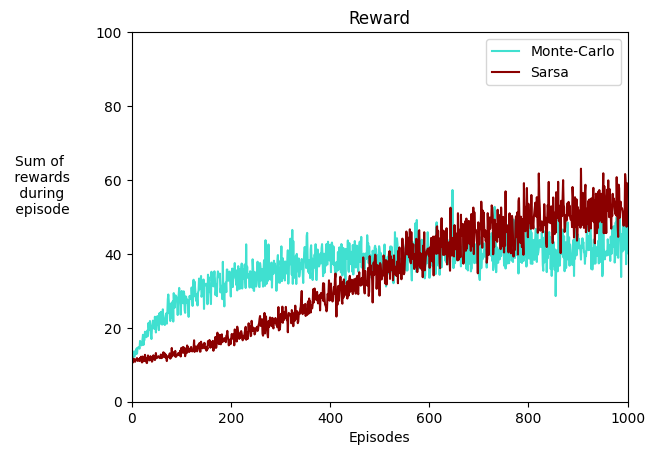

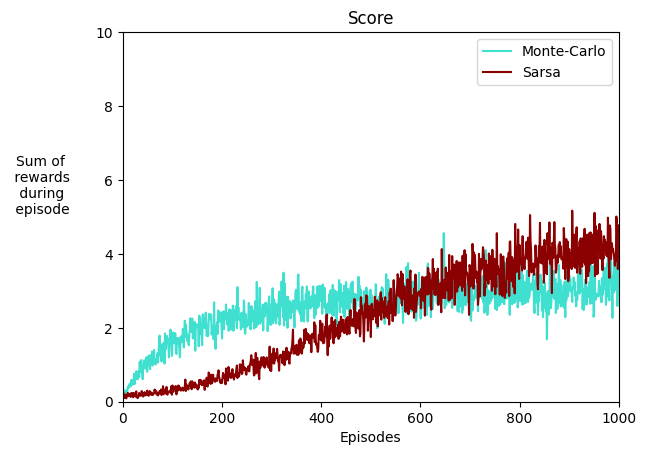

In [ ]:
colors = {"Monte-Carlo": "turquoise", "Sarsa": "darkred"}
for algorithm in ["Monte-Carlo", "Sarsa"]:
    plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm, color=colors[algorithm])
plt.title('Reward')
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,1000)
plt.ylim(0,100)
plt.legend()
plt.show()

colors = {"Monte-Carlo": "turquoise", "Sarsa": "darkred"}
for algorithm in ["Monte-Carlo", "Sarsa"]:
    plt.plot(np.mean(all_scores_sums[algorithm], axis=0), label=algorithm, color=colors[algorithm])
plt.title('Score')
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,1000)
plt.ylim(0,10)
plt.legend()
plt.show()

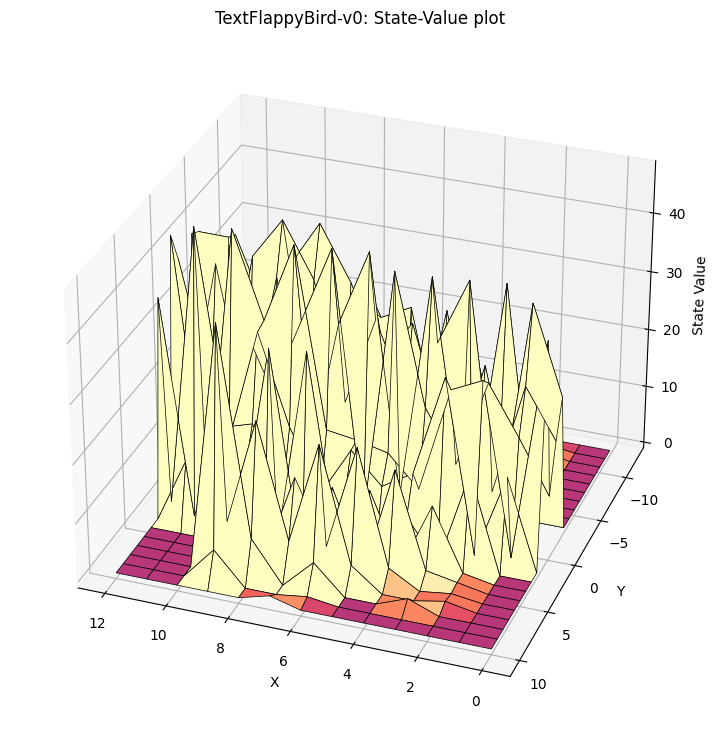

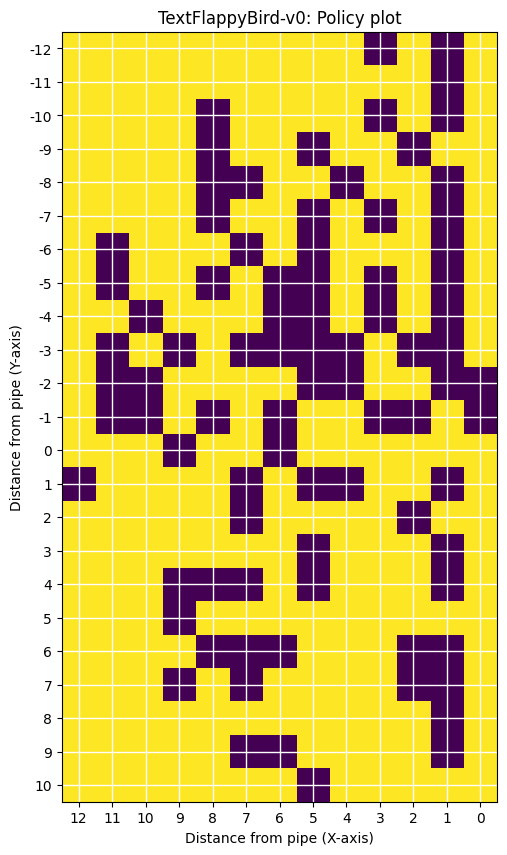

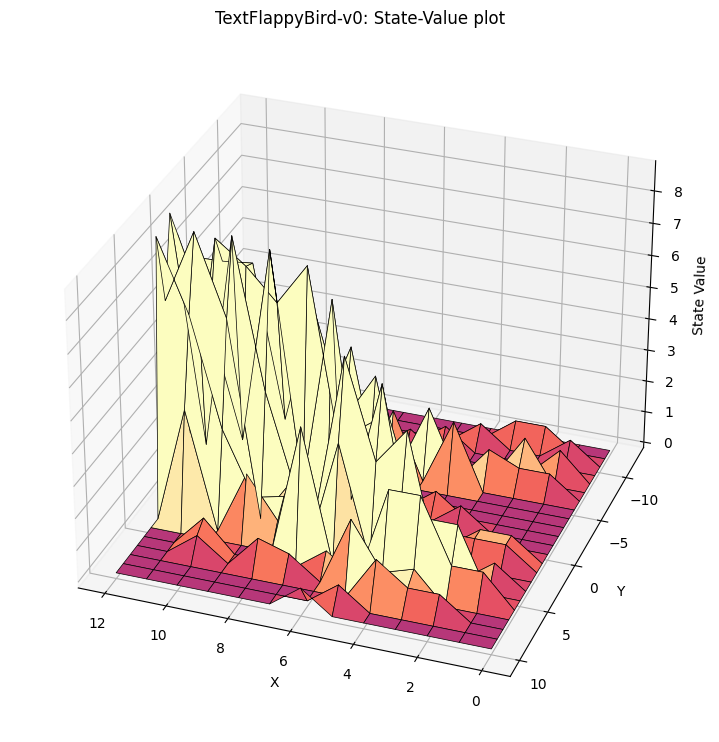

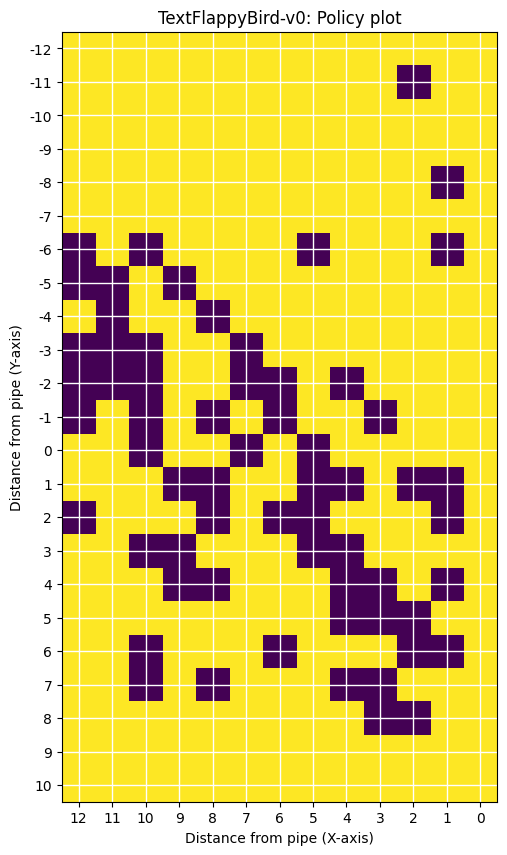

In [ ]:
for algo in ["Monte-Carlo", "Sarsa"]:
  q = {}
  for state_action, value in Q_tables[algo].items():
      state, action = state_action
      if state not in q or value > q[state][1]:
          q[state] = (action, value)

  # plot state-value function
  V = dict((k, v[1]) for k, v in q.items())
  plot_flappybird_values(V)

  # plot policy
  policy = dict((k, v[0]) for k, v in q.items())
  plot_flappybird_policy(policy)

# Parameters Optimization

## Epsilon

100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


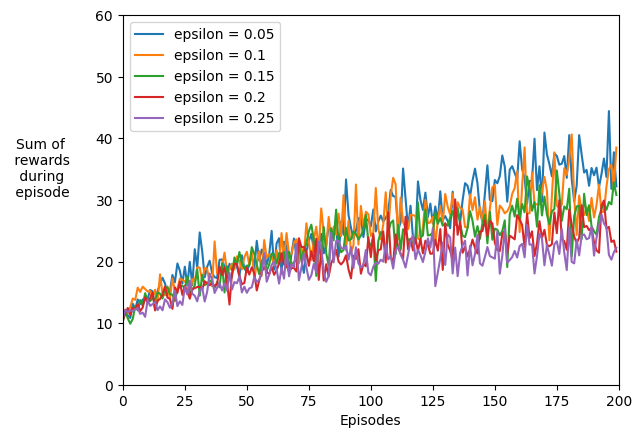

100%|██████████| 50/50 [00:12<00:00,  3.85it/s]


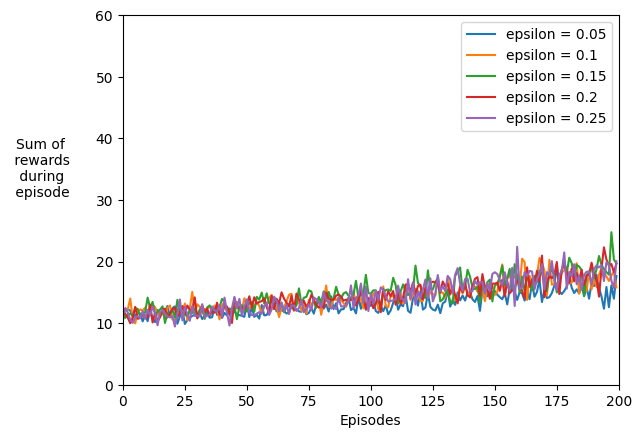

In [ ]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
all_scores = [] # Contains the scores obtained for each run

agents = {
    "Monte-Carlo": MonteCarloAgent,
    "Sarsa": SarsaAgent,
}
agent_info = {"num_actions": 2, "num_states": 14*22, "epsilon": 0.1, "step_size": 0.7, "discount": 1.0}
agent_info["seed"] = 0

env_info = {}
num_runs = 50 # The number of runs
num_episodes = 200 # The number of episodes in each run
eps_range = (0.05, 0.1, 0.15, 0.2, 0.25)

####### Monte-Carlo ###############
algorithm = "Monte-Carlo"
for eps in eps_range:
  agent_info["epsilon"] = eps
  all_reward_sum, _, all_state_visit, _  = simulate_test(algorithm, env, agents, agent_info, num_runs, num_episodes)
  all_reward_sums[eps] = all_reward_sum
  all_state_visits[eps] = all_state_visit


for eps in eps_range:
    plt.plot(np.mean(all_reward_sums[eps], axis=0), label=f'epsilon = {eps}')
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,200)
plt.ylim(0,60)
plt.legend()
plt.show()

####### Sarsa ###############
algorithm = "Sarsa"
for eps in eps_range:
  agent_info["epsilon"] = eps
  all_reward_sum, _, all_state_visit, _ = simulate_test(algorithm, env, agents, agent_info, num_runs, num_episodes)
  all_reward_sums[eps] = all_reward_sum
  all_state_visits[eps] = all_state_visit

for eps in eps_range:
    plt.plot(np.mean(all_reward_sums[eps], axis=0), label=f'epsilon = {eps}')
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,200)
plt.ylim(0,60)
plt.legend()
plt.show()

## Step-size ($\alpha$)

100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


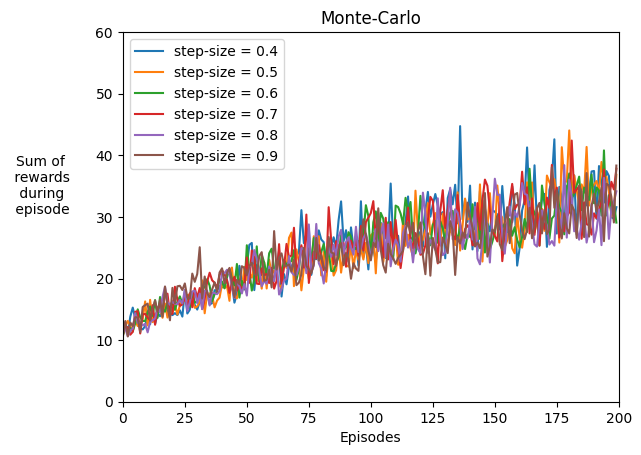

100%|██████████| 50/50 [00:09<00:00,  5.46it/s]


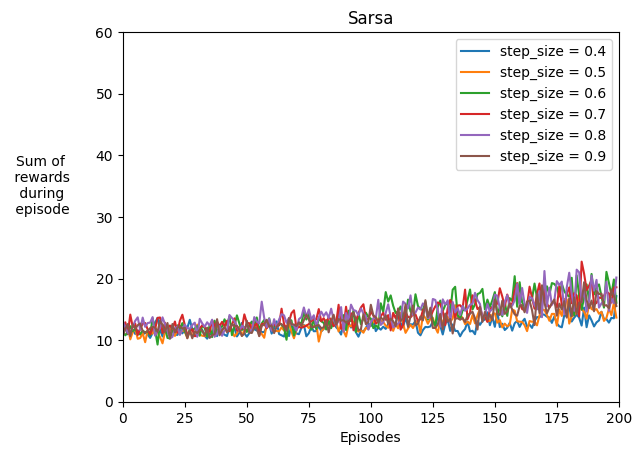

In [ ]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
all_scores = [] # Contains the scores obtained for each run

agents = {
    "Monte-Carlo": MonteCarloAgent,
    "Sarsa": SarsaAgent,
}
agent_info = {"num_actions": 2, "num_states": 14*22, "epsilon": 0.1, "step_size": 0.7, "discount": 1.0}
agent_info["seed"] = 0

env_info = {}
num_runs = 50 # The number of runs
num_episodes = 200 # The number of episodes in each run
step_range = (0.4, 0.5, 0.6, 0.7, 0.8, 0.9)

####### Monte-Carlo ###############
algorithm = "Monte-Carlo"
for step_size in step_range:
  agent_info["step_size"] = step_size
  all_reward_sum, _, all_state_visit, _  = simulate_test(algorithm, env, agents, agent_info, num_runs, num_episodes)
  all_reward_sums[step_size] = all_reward_sum
  all_state_visits[step_size] = all_state_visit


for step_size in step_range:
    plt.plot(np.mean(all_reward_sums[step_size], axis=0), label=f'step-size = {step_size}')
plt.title("Monte-Carlo")
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,200)
plt.ylim(0,60)
plt.legend()
plt.show()

####### Sarsa ###############
algorithm = "Sarsa"
for step_size in step_range:
  agent_info["step_size"] = step_size
  all_reward_sum, _, all_state_visit, _ = simulate_test(algorithm, env, agents, agent_info, num_runs, num_episodes)
  all_reward_sums[step_size] = all_reward_sum
  all_state_visits[step_size] = all_state_visit

for step_size in step_range:
    plt.plot(np.mean(all_reward_sums[step_size], axis=0), label=f'step_size = {step_size}')
plt.title("Sarsa")
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,200)
plt.ylim(0,60)
plt.legend()
plt.show()

# Different Configuration

## Pipe gap setting

In [ ]:
agents = {
    "Monte-Carlo": MonteCarloAgent,
    "Sarsa": SarsaAgent,
}
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
all_scores = [] # Contains the scores obtained for each run
Q_tables = {}
agent_info = {"num_actions": 2, "num_states": 14*22, "epsilon": 0.1, "step_size": 0.7, "discount": 1.0}
agent_info["seed"] = 0

env_info = {}
num_runs = 500 # The number of runs
num_episodes = 200 # The number of episodes in each run

pipe_gaps = [1, 2, 3, 4, 5, 6]

algorithm = "Monte-Carlo"
for pipe_gap in pipe_gaps:
  env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=pipe_gap)
  all_reward_sum, all_score, all_state_visit, Q_table = simulate_test(algorithm, env, agents, agent_info, num_runs, num_episodes)
  all_reward_sums[pipe_gap] = all_reward_sum
  all_state_visits[pipe_gap] = all_state_visit

for pipe_gap in pipe_gaps:
    plt.plot(np.mean(all_reward_sums[pipe_gap], axis=0), label=f'pipe gap = {pipe_gap}')
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,200)
plt.ylim(0,60)
plt.legend()
plt.show()

algorithm = "Sarsa"
for pipe_gap in pipe_gaps:
  env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=pipe_gap)
  all_reward_sum, all_score, all_state_visit, Q_table = simulate_test(algorithm, env, agents, agent_info, num_runs, num_episodes)
  all_reward_sums[pipe_gap] = all_reward_sum
  all_state_visits[pipe_gap] = all_state_visit

for pipe_gap in pipe_gaps:
    plt.plot(np.mean(all_reward_sums[pipe_gap], axis=0), label=f'pipe gap = {pipe_gap}')
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,200)
plt.ylim(0,60)
plt.legend()
plt.show()

NameError: name 'MonteCarloAgent' is not defined

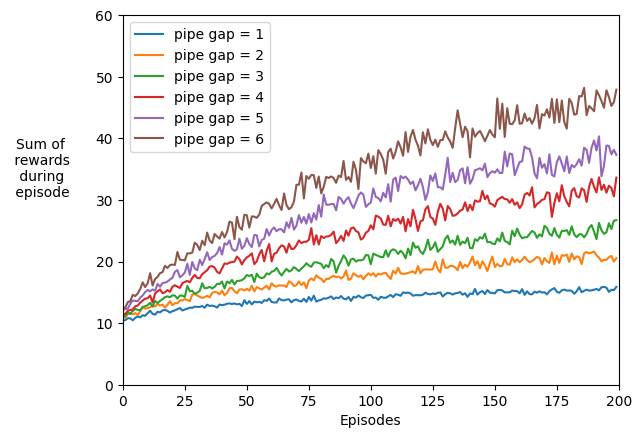

## Height of game space

100%|██████████| 500/500 [02:19<00:00,  3.59it/s]


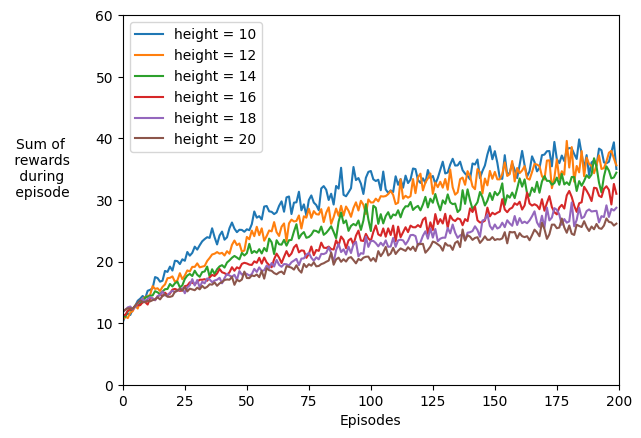

100%|██████████| 500/500 [01:34<00:00,  5.28it/s]


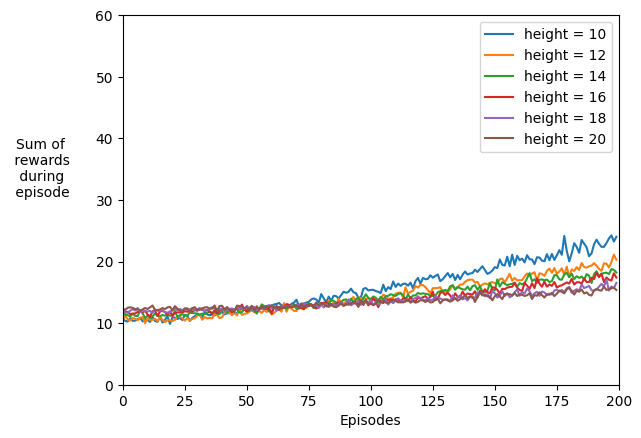

In [ ]:
agents = {
    "Monte-Carlo": MonteCarloAgent,
    "Sarsa": SarsaAgent,
}
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
all_scores = [] # Contains the scores obtained for each run
Q_tables = {}
agent_info = {"num_actions": 2, "num_states": 14*22, "epsilon": 0.1, "step_size": 0.7, "discount": 1.0}
agent_info["seed"] = 0

env_info = {}
num_runs = 500 # The number of runs
num_episodes = 200 # The number of episodes in each run

heights = [10, 12, 14, 16, 18, 20]

algorithm = "Monte-Carlo"
for height in heights:
  env = gym.make('TextFlappyBird-v0', height=height, width=20, pipe_gap=4)
  all_reward_sum, all_score, all_state_visit, Q_table= simulate_test(algorithm, env, agents, agent_info, num_runs, num_episodes)
  all_reward_sums[height] = all_reward_sum
  all_state_visits[height] = all_state_visit

for height in heights:
    plt.plot(np.mean(all_reward_sums[height], axis=0), label=f'height = {height}')
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,200)
plt.ylim(0,60)
plt.legend()
plt.show()

algorithm = "Sarsa"
for height in heights:
  env = gym.make('TextFlappyBird-v0', height=height, width=20, pipe_gap=4)
  all_reward_sum, all_score, all_state_visit, Q_table = simulate_test(algorithm, env, agents, agent_info, num_runs, num_episodes)
  all_reward_sums[height] = all_reward_sum
  all_state_visits[height] = all_state_visit

for height in heights:
    plt.plot(np.mean(all_reward_sums[height], axis=0), label=f'height = {height}')
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,200)
plt.ylim(0,60)
plt.legend()
plt.show()

# Original environment

In [23]:
!pip install flappy-bird-gym

  Using cached flappy_bird_gym-0.3.0-py3-none-any.whl (558 kB)
  Using cached gym-0.18.3.tar.gz (1.6 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [5]:
import time
import flappy_bird_gym
env = flappy_bird_gym.make("FlappyBird-v0")

obs = env.reset()
while True:
    # Next action:
    # (feed the observation to your agent here)
    action = ...  # env.action_space.sample() for a random action

    # Processing:
    obs, reward, done, info = env.step(action)

    # Rendering the game:
    # (remove this two lines during training)
    env.render()
    time.sleep(1 / 30)  # FPS

    # Checking if the player is still alive
    if done:
        break

env.close()

ModuleNotFoundError: No module named 'flappy_bird_gym'